# 📚 SBERT Fine-Tuning on Reduced Dataset (VSCode Version)

This notebook fine-tunes **SBERT (Sentence-BERT)** on each book from the reduced dataset (10 samples per book), and plots **training loss vs. epochs**.

✅ Loads text files from the local folder `./sbert_books_data_reduced`
✅ Fine-tunes SBERT on each book
✅ Plots loss graphs

Let's get started! 🚀

In [3]:
# 🔧 Step 1: Install Required Libraries
! pip install sentence-transformers torch matplotlib

  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)


  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.3-py3-none-any.whl.metadata (40 kB)
  Using cached huggingface_hub-0.32.2-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
Using cached huggingface_hub-0.32.2-py3-none-any.whl (509 kB)
Using cached transformers-4.52.3-py3-none-any.whl (10.5 MB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)


### 📂 Step 2: Ensure Reduced Data Files Are Ready
Place your reduced `.txt` files in a folder named `./sbert_books_data_reduced`.
This folder should be in the same directory as this notebook.

In [5]:
import os
if not os.path.exists('./sbert_book'):
    print("❌ Error: './sbert_book' folder not found.")
else:
    print("✅ './sbert_book' folder found.")

✅ './sbert_book' folder found.


Using device: cpu

Fine-tuning SBERT on: A-Dictionary-for-Psychotherapists.txt
Epoch 1/3 - Loss: 0.0621
Epoch 2/3 - Loss: 0.0621
Epoch 3/3 - Loss: 0.0621


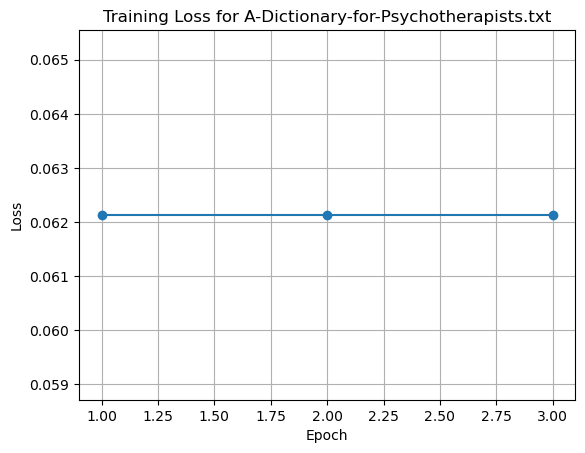


Fine-tuning SBERT on: MentalHealthGuidebookCovid19.txt
Epoch 1/3 - Loss: 0.0526
Epoch 2/3 - Loss: 0.0526
Epoch 3/3 - Loss: 0.0526


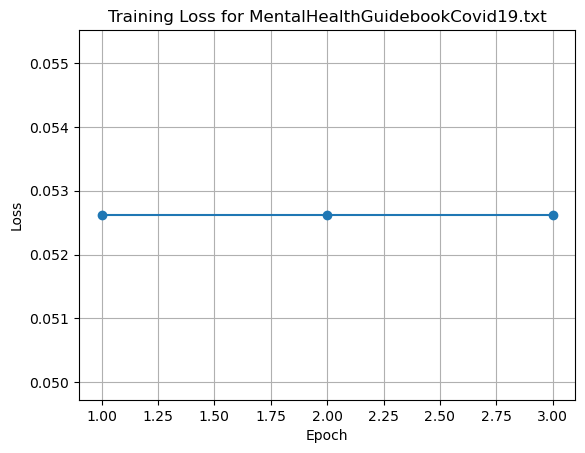


Fine-tuning SBERT on: mental_health_one.txt
Epoch 1/3 - Loss: 0.0746
Epoch 2/3 - Loss: 0.0746
Epoch 3/3 - Loss: 0.0746


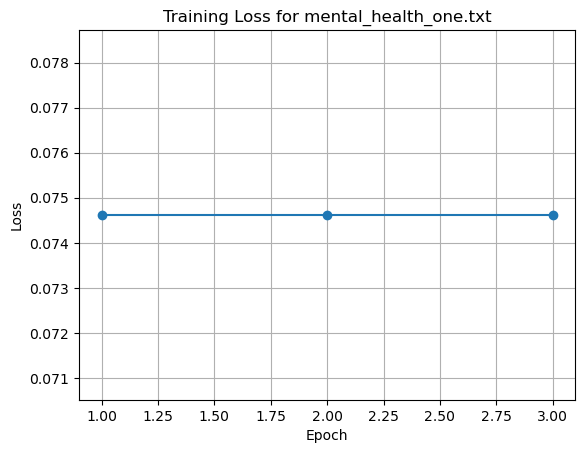


Fine-tuning SBERT on: psychological-disorders.txt
Epoch 1/3 - Loss: 0.0274
Epoch 2/3 - Loss: 0.0274
Epoch 3/3 - Loss: 0.0274


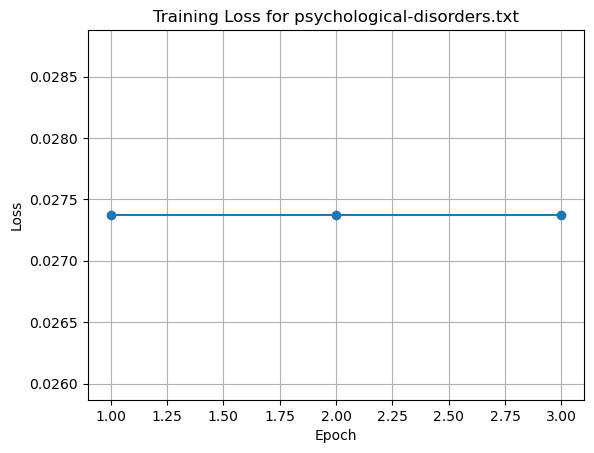


Fine-tuning SBERT on: survival-kit-major-mental-illnesses-signs-and-syptoms.txt
Epoch 1/3 - Loss: 0.0666
Epoch 2/3 - Loss: 0.0666
Epoch 3/3 - Loss: 0.0666


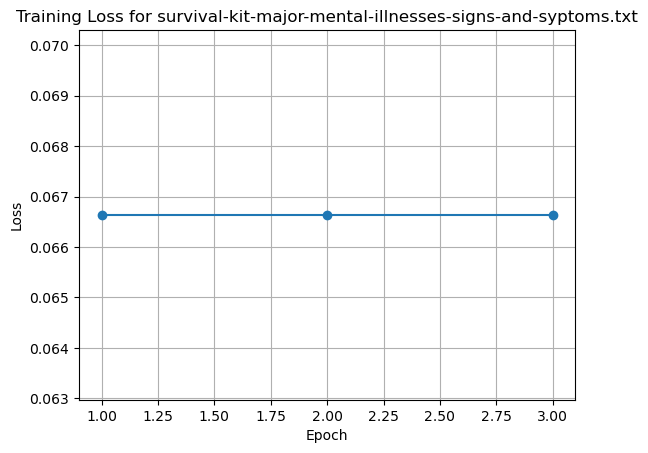

In [19]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

book_dir = './sbert_book'
book_files = [f for f in os.listdir(book_dir) if f.endswith('.txt')]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

for book_file in book_files:
    print(f"\nFine-tuning SBERT on: {book_file}")
    with open(os.path.join(book_dir, book_file), 'r', encoding='utf-8') as f:
        text = f.read()
    sentences = [s.strip() for s in text.split('\n') if len(s.strip()) > 30]

    if len(sentences) < 2:
        print(f"Skipping {book_file} (not enough data)")
        continue

    model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CosineEmbeddingLoss()
    num_epochs = 3
    batch_size = 4
    loss_values = []

    # Prepare sentence pairs and labels
    pairs = []
    labels = []
    for sentence in sentences:
        pairs.append((sentence, sentence))
        labels.append(1)
        pairs.append((sentence, "Random unrelated sentence."))
        labels.append(-1)  # For CosineEmbeddingLoss: -1 means dissimilar

    num_batches = len(pairs) // batch_size + int(len(pairs) % batch_size != 0)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i in range(num_batches):
            batch_pairs = pairs[i*batch_size:(i+1)*batch_size]
            batch_labels = torch.tensor(labels[i*batch_size:(i+1)*batch_size], dtype=torch.float).to(device)

            sentences1 = [p[0] for p in batch_pairs]
            sentences2 = [p[1] for p in batch_pairs]

            # Use model's encode with output_value='token_embeddings' and get_grad for gradient tracking
            embeddings1 = model.encode(sentences1, convert_to_tensor=True, show_progress_bar=False, device=device, output_value='sentence_embedding')
            embeddings2 = model.encode(sentences2, convert_to_tensor=True, show_progress_bar=False, device=device, output_value='sentence_embedding')

            embeddings1.requires_grad = True
            embeddings2.requires_grad = True

            optimizer.zero_grad()
            loss = criterion(embeddings1, embeddings2, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        loss_values.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # Plot loss
    plt.figure()
    plt.plot(range(1, num_epochs+1), loss_values, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training Loss for {book_file}")
    plt.grid(True)
    plt.show()
